![banner.jpeg](data\banner.JPG)

# Laboratorio Número 2 - Regresión

El objetivo de este notebook es construir un modelo analítico para estimar el número de muertes por cáncer por cada 100.000 habitantes a partir de un conjunto de variables observadas. Este modelo no solo debe abordar la tarea de regresión, sino también la automatización mediante pipelines para su implementación en entornos de producción. El objetivo final es extraer información relevante para el negocio a partir de los resultados obtenidos, permitiendo a la Organización Mundial de la Salud y a los gobiernos locales identificar poblaciones vulnerables y asignar recursos de manera eficiente para programas de diagnóstico temprano, tratamiento y financiamiento de la investigación en cáncer. 

Integrantes Grupo 40:

* Ronald Pardo - 202111309
* Jefferson Hernandez - 202120242
* Samuel Goncalves - 2021200000

Este notebook se encuentra dividido en las siguientes secciones:

1. [Carga de datos](#1-carga-de-datos)
2. [Entendimiento de datos](#2-entendimiento-de-datos)
3. [Limpieza de datos](#3-limpieza-de-datos)
4. [Preparacion de datos](#4-preparacion-de-datos)
5. [Particionamiento del conjunto de datos en entrenamiento y prueba](#5-particionamiento-del-conjunto-de-datos-en-entrenamiento-y-prueba)
6. [Entrenamiento de un primer modelo de regresion lineal](#6-entrenamiento-de-un-primer-modelo-de-regresion-lineal)
7. [Entrenamiento de un segundo modelo aplicando normalizacion](#7-entrenamiento-de-un-segundo-modelo-aplicando-normalizacion)
8. [Eleccion de mejor modelo de regresion](#8-eleccion-de-mejor-modelo-de-regresion)
8. [Implementación del pipeline con todas las transformaciones requeridas para la generación de predicciones](#9-implementación-del-pipeline-con-todas-las-transformaciones-requeridas-para-la-generación-de-predicciones)
10. [Exploración de los supuestos de la regresión a partir del mejor modelo](#10-exploración-de-los-supuestos-de-la-regresión-a-partir-del-mejor-modelo)
11. [Desarrollo de las transformaciones complementarias para cumplir con los supuestos de la regresión](#11-desarrollo-de-las-transformaciones-complementarias-para-cumplir-con-los-supuestos-de-la-regresión)
12. [Interpretación de los coeficientes del modelo](#12-interpretación-de-los-coeficientes-del-modelo)
13. [Presentación para CompuAlpes con resultados a nivel cuantitativo y cualitativo del mejor modelo construido](#13-presentación-para-compualpes-con-resultados-a-nivel-cuantitativo-y-cualitativo-del-mejor-modelo-construido)
14. [Recomendaciones dadas a CompuAlpes y visualizaciones extraidas del notebook y/o tablero de control](#14-recomendaciones-dadas-a-compualpes-y-visualizaciones-extraidas-del-notebook-y-o-tablero-de-control)
15. [Tablero de control](#15-tablero-de-control)
16. [Persistencia del archivo de predicciones sobre los datos de prueba (CSV)](#16-persistencia-del-archivo-de-predicciones-sobre-los-datos-de-prueba-csv)

 ##### **1. Carga de datos**

In [3]:
import numpy as np
import pandas as pd
import math

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

In [5]:
train_data = pd.read_csv("data/train_data.csv")
val_data = pd.read_csv("data/val_data.csv")

In [6]:
train_data.shape, val_data.shape

((2132, 34), (915, 33))

In [7]:
extra_columns_train = set(train_data.columns) - set(val_data.columns)
extra_columns_train

{'deathRate'}

In [8]:
train_data.dtypes

avgAnnCount                float64
avgDeathsPerYear             int64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
binnedInc                   object
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
Geography                   object
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite                   float64
PctBlack            

In [9]:
val_data.dtypes

avgAnnCount                float64
avgDeathsPerYear             int64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
binnedInc                   object
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
Geography                   object
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite                   float64
PctBlack            

In [10]:
train_data.sample(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,MedianAgeFemale,Geography,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate
1890,178.0,78,469.4,41326,28946,16.9,0.000000,"(40362.7, 42724.4]",42.9,41.5,44.0,"Giles County, Tennessee",2.49,52.4,12.5,36.2,NaN,6.4,42.3,9.7,50.6,9.9,64.4,46.8,40.8,37.9,20.1,86.099693,10.034889,0.659781,0.939583,51.854475,4.447588,199.9
1927,183.0,94,359.6,54666,42537,10.5,822.813080,"(54545.6, 61494.5]",39.8,37.9,40.8,"Fulton County, Ohio",2.59,59.8,15.7,36.2,NaN,8.9,40.8,11.5,62.7,6.7,78.8,NaN,57.1,28.9,14.3,94.221490,0.567259,0.329528,3.318818,60.484318,6.632331,181.2
1697,4974.0,1809,506.5,54865,864840,12.3,154.941955,"(54545.6, 61494.5]",40.8,39.4,42.1,"Macomb County, Michigan",2.52,49.5,13.6,29.2,NaN,9.2,30.6,15.2,58.2,9.0,73.6,57.5,51.5,31.9,15.0,83.194238,10.288421,3.465120,0.554003,48.706667,4.707995,177.8
62,97.0,41,375.5,39551,16272,16.3,0.000000,"(37413.8, 40362.7]",48.9,47.5,50.4,"Idaho County, Idaho",2.38,58.4,25.8,53.6,NaN,1.8,37.3,14.9,48.5,6.4,63.1,41.3,31.4,42.1,17.5,93.863413,0.147131,0.275871,0.232957,57.724442,5.367647,162.0
1182,80.0,33,528.1,49456,9818,13.7,407.414952,"(48021.6, 51046.4]",46.0,43.0,48.7,"Calhoun County, Iowa",2.19,55.8,19.9,30.8,NaN,5.0,37.0,13.1,56.9,4.0,74.3,50.5,40.8,40.6,17.3,96.156950,1.351624,0.292516,0.211822,52.076977,6.876457,181.5


In [11]:
val_data.sample(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,MedianAgeFemale,Geography,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
643,146.0,66,462.7,33428,25563,30.4,0.0,"[22640, 34218.1]",39.1,37.3,40.5,"Marion County, Mississippi",2.58,50.3,27.6,30.5,NaN,3.4,36.5,8.7,45.5,10.4,48.3,36.1,31.2,45.0,27.1,65.762764,32.295377,0.011490,0.578345,48.838394,7.310838
679,119.0,41,390.1,80835,32756,7.9,0.0,"(61494.5, 125635]",37.0,36.6,37.4,"Juneau City and Borough, Alaska",2.62,48.7,15.7,42.9,NaN,7.9,21.1,24.5,68.4,5.2,75.3,58.8,54.4,21.6,8.7,68.995727,1.269558,6.811964,1.186561,49.380882,5.601633
119,227.0,85,471.4,56573,39165,14.7,0.0,"(54545.6, 61494.5]",43.7,42.7,44.8,"Fayette County, Tennessee",2.58,56.4,14.8,36.9,42.6,5.7,35.8,15.9,54.1,8.5,71.8,55.6,45.8,32.9,15.6,69.619210,27.649817,0.669861,1.076931,58.143608,5.282646
296,72.0,31,392.1,45721,13383,14.3,0.0,"(45201, 48021.6]",42.9,41.6,44.7,"Goshen County, Wyoming",2.35,52.9,13.3,39.2,NaN,1.8,29.9,14.1,55.0,6.8,67.1,47.0,40.1,37.8,16.1,91.922623,0.361784,0.243650,4.282339,52.804606,7.372914
167,105.0,57,438.4,34631,18208,23.3,0.0,"(34218.1, 37413.8]",40.5,38.7,42.1,"New Madrid County, Missouri",2.49,47.4,16.3,57.3,NaN,1.4,41.3,6.8,50.1,8.8,48.3,37.9,32.9,43.3,26.2,81.462169,16.158818,0.092336,0.260714,44.487374,5.174548


##### **2. Entendimiento de datos**

In [12]:
train_data.describe()

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate
count,2132.000000,2132.000000,2132.000000,2132.000000,2.132000e+03,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,528.000000,2132.000000,2132.000000,2132.000000,2017.000000,2132.000000,2132.000000,1704.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,613.385785,183.537992,448.816467,47029.474203,1.025064e+05,16.889681,158.003002,44.298687,39.559475,42.140009,2.479013,51.756285,18.134897,34.981660,41.151705,6.201173,34.949578,13.225797,54.119137,7.843574,64.393011,48.407688,41.237899,36.305113,19.282786,83.686321,9.132512,1.260485,1.953356,51.228950,5.643918,179.000047
std,1435.393846,507.649052,53.582307,12107.930677,3.442282e+05,6.415614,533.636824,39.522898,5.208212,5.272267,0.421538,6.925242,8.091987,9.024105,11.046405,4.628540,7.056699,5.395211,8.398898,3.448596,10.670887,9.985504,9.326155,7.847326,6.136426,16.588379,14.613785,2.745672,3.484569,6.565620,1.980214,27.416156
min,6.000000,3.000000,201.300000,22640.000000,8.290000e+02,3.200000,0.000000,23.500000,22.800000,22.800000,0.022100,23.100000,0.000000,0.000000,7.100000,0.000000,7.500000,2.500000,17.600000,0.700000,22.300000,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000,59.700000
25%,77.000000,28.000000,421.600000,38875.750000,1.154725e+04,12.200000,0.000000,37.700000,36.300000,39.000000,2.360000,47.775000,12.700000,29.200000,34.000000,3.100000,30.600000,9.300000,48.600000,5.500000,57.175000,41.275000,34.600000,30.975000,14.900000,77.560360,0.614838,0.263542,0.278374,47.749949,4.520411,161.875000
50%,174.500000,62.000000,453.549422,45207.000000,2.693200e+04,15.900000,0.000000,40.900000,39.600000,42.300000,2.500000,52.300000,17.100000,34.700000,40.600000,5.400000,35.400000,12.300000,54.400000,7.600000,65.300000,48.800000,41.300000,36.400000,18.900000,90.122747,2.214754,0.538013,0.781727,51.595091,5.383877,178.550000
75%,515.250000,141.000000,481.600000,52376.250000,6.663525e+04,20.300000,79.275307,44.000000,42.600000,45.400000,2.630000,56.500000,22.425000,40.700000,46.725000,8.300000,39.800000,16.100000,60.300000,9.700000,72.100000,55.500000,47.600000,41.425000,23.200000,95.600016,10.709158,1.190457,2.171349,55.398869,6.478029,195.300000
max,38150.000000,14010.000000,1014.200000,125635.000000,1.017029e+07,47.400000,9439.200444,619.200000,64.700000,65.700000,3.970000,72.500000,64.100000,65.700000,79.000000,51.800000,54.800000,42.200000,80.100000,29.400000,92.300000,78.200000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,37.859023,78.075397,21.326165,293.900000


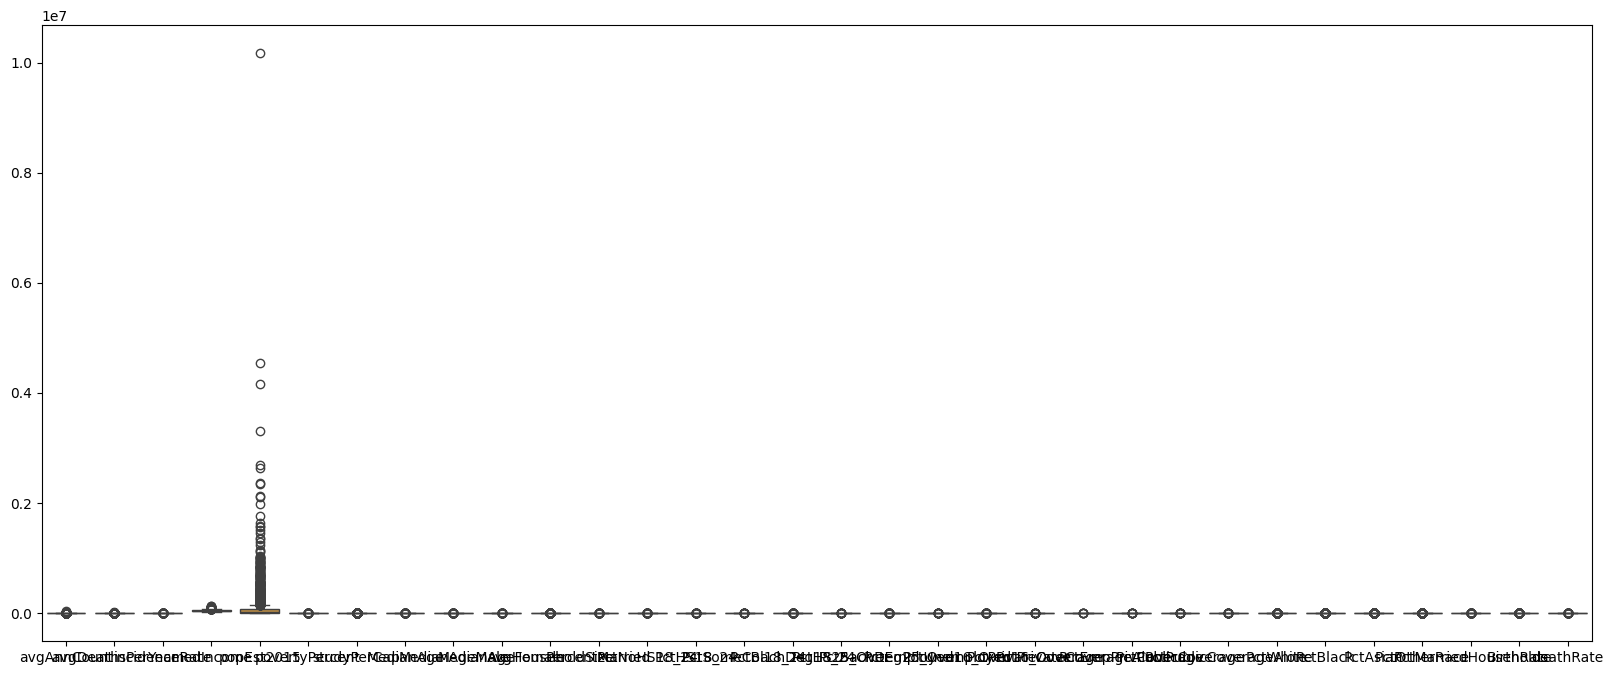

In [13]:
fig = plt.figure(figsize=(20,8))
ax = sns.boxplot(data=train_data, orient="v")

In [14]:
# Inicialmente identificamos a las columnas que sean de tipo object para ver si podemos convertirlas a numéricas
train_data.select_dtypes(include=["object"]).head()

,binnedInc,Geography
0,"(34218.1, 37413.8]","Gregory County, South Dakota"
1,"(48021.6, 51046.4]","Taylor County, Wisconsin"
2,"(54545.6, 61494.5]","Bowman County, North Dakota"
3,"[22640, 34218.1]","Quitman County, Georgia"
4,"(37413.8, 40362.7]","Owyhee County, Idaho"


In [16]:
"""
Luego nos damos cuenta que binnedInc hace referencia al ingreso mediano per capita (clasificado por decil), por lo cual podriamos tomar las siguientes decisiones:

1. Convertir las categorias a valores numéricos, por ejemplo, 1-10 -> 5.5
2. Mantener una columna para el rango inferior y otra para el rango superior

Antes de decidir vamos a ver diferencia entre los valores de binnedInc, para ver si es significativa
binnedInc	Geography
0	(34218.1, 37413.8]	Gregory County, South Dakota
1	(48021.6, 51046.4]	Taylor County, Wisconsin
2	(54545.6, 61494.5]	Bowman County, North Dakota
3	[22640, 34218.1]	Quitman County, Georgia
4	(37413.8, 40362.7]	Owyhee County, Idaho
"""

# Obtener parejas de valores únicos de binnedInc en una lista para visualizarlas de la siguiente forma: pairs = [(a,b),(c.d),...]
pairs = train_data["binnedInc"].unique()
for i in range(len(pairs)):
    pairs[i] = pairs[i].strip("[]()").split(", ")
    pairs[i] = (float(pairs[i][0]), float(pairs[i][1]))
print("\nPairs:")
print(pairs[0])
print(pairs)
print("\n")

# Value counts de binnedInc
print(f"Unique values from original data:\n{train_data['binnedInc'].unique()}\n")
print(f"Len of uniques: {len(train_data['binnedInc'].unique())}\nLen of pairs: {len(pairs)}\n")

# Diferencia promedio entre los valores de binnedInc, diferencia maxima y minima, y desviacion estandar
diffs = [abs(pair[1] - pair[0]) for pair in pairs]
print(f"Mean difference between pairs: {np.mean(diffs)}")
print(f"Max difference between pairs: {np.max(diffs)}\nPair with max difference: {pairs[np.argmax(diffs)]}")
print(f"Min difference between pairs: {np.min(diffs)}")
print(f"Standard deviation of differences: {np.std(diffs)}")




Pairs:
(34218.1, 37413.8)
[(34218.1, 37413.8) (48021.6, 51046.4) (54545.6, 61494.5)
 (22640.0, 34218.1) (37413.8, 40362.7) (40362.7, 42724.4)
 (51046.4, 54545.6) (61494.5, 125635.0) (42724.4, 45201.0)
 (45201.0, 48021.6)]


Unique values from original data:
['(34218.1, 37413.8]' '(48021.6, 51046.4]' '(54545.6, 61494.5]'
 '[22640, 34218.1]' '(37413.8, 40362.7]' '(40362.7, 42724.4]'
 '(51046.4, 54545.6]' '(61494.5, 125635]' '(42724.4, 45201]'
 '(45201, 48021.6]']

Len of uniques: 10
Len of pairs: 10

Mean difference between pairs: 10299.5
Max difference between pairs: 64140.5
Pair with max difference: (61494.5, 125635.0)
Min difference between pairs: 2361.7000000000044
Standard deviation of differences: 18153.555113971477


In [17]:
""" 
Mean difference between pairs: 10299.5
Max difference between pairs: 64140.5
Pair with max difference: (61494.5, 125635.0)
Min difference between pairs: 2361.7000000000044
Standard deviation of differences: 18153.555113971477

Nos podemos dar cuenta de que el valor de la pareja con el valor maximo de diferencia tiene un valor de 61494.5, el cual es mayor comparado al resto de valores.

Adicionalmente, teniendo en cuenta que esta columna hace referencia a ingresos y los los ingresos mayores son mucho mayores que los menores, entonces podriamos inferir que estos hacen referencia a ingresos altos, por lo que puede existir diferencia significativa entre los valores de rangos de zonas ricas, por lo que podriamos considerar convertirlos a un promedio de los valores de la pareja, por ejemplo, (34218.1, 37413.8] -> 35815.95

Adicionalmente, durante la limpieza muchos de estos valores con diferencias entremadamente grande podrian ser reemplazados por la media debido a que podrian ser considerado outliers y aportan poco como variables ya que al tener una diferencia de rango tan grande, representa mucha poblacion a la vez y por lo tanto no es especifico o util para el modelo (es como tener una linea vertical en la grafica de la regresion, no existe funcion en los reales que pueda representar tal naturaleza y por lo tanto valores asi crean sesgos sobre el modelo).
"""

"""  
En lo que respecta a geografia, no tenemos valores de latitud y longitud por lo que no podriamos usarlo como un valor importante para el modelo.
"""

# features = todas las columnas menos Geography, deathRate

features = train_data.columns.drop(["Geography", "deathRate"])
features

Index(['avgAnnCount', 'avgDeathsPerYear', 'incidenceRate', 'medIncome',
       'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc', 'MedianAge',
       'MedianAgeMale', 'MedianAgeFemale', 'AvgHouseholdSize',
       'PercentMarried', 'PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24',
       'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over',
       'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage',
       'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage',
       'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian',
       'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate'],
      dtype='object')

In [19]:
"""   
Analisis de completitud de datos
"""

train_data.isnull().sum() / len(train_data)

avgAnnCount                0.000000
avgDeathsPerYear           0.000000
incidenceRate              0.000000
medIncome                  0.000000
popEst2015                 0.000000
povertyPercent             0.000000
studyPerCap                0.000000
binnedInc                  0.000000
MedianAge                  0.000000
MedianAgeMale              0.000000
MedianAgeFemale            0.000000
Geography                  0.000000
AvgHouseholdSize           0.000000
PercentMarried             0.000000
PctNoHS18_24               0.000000
PctHS18_24                 0.000000
PctSomeCol18_24            0.752345
PctBachDeg18_24            0.000000
PctHS25_Over               0.000000
PctBachDeg25_Over          0.000000
PctEmployed16_Over         0.053940
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctPrivateCoverageAlone    0.200750
PctEmpPrivCoverage         0.000000
PctPublicCoverage          0.000000
PctPublicCoverageAlone     0.000000
PctWhite                   0

La columna PctSomeCol18_24 tiene un porcentaje de nulos de un 75%, lo cual es extremadamente alto y cualquier intento de reemplazar valores nulos con promedios o medianas puede no ser representativo de la naturaleza de los datos. Por lo cual se considera como mejor decision no tener en cuenta a esta columna en el modelo.

En lo que respecta a las columnas PctPrivateCoverageAlone y PctEmployed16_Over se puede considerar reemplazar a los valores nulos con la mediana de esta columna, debido a que se cuentan con la cantidad de datos necesaria para representar lo suficiente a la naturaleza de estos, ademas de que la mediana es menos sensible a outliers.

In [20]:
"""   
Analisis de unicidad de datos
"""

train_data.nunique() / len(train_data)

avgAnnCount                0.352251
avgDeathsPerYear           0.233114
incidenceRate              0.589118
medIncome                  0.968105
popEst2015                 0.987805
povertyPercent             0.148687
studyPerCap                0.361163
binnedInc                  0.004690
MedianAge                  0.134146
MedianAgeMale              0.130863
MedianAgeFemale            0.132270
Geography                  1.000000
AvgHouseholdSize           0.083490
PercentMarried             0.159006
PctNoHS18_24               0.175891
PctHS18_24                 0.200281
PctSomeCol18_24            0.135084
PctBachDeg18_24            0.097561
PctHS25_Over               0.159475
PctBachDeg25_Over          0.125235
PctEmployed16_Over         0.185272
PctUnemployed16_Over       0.085835
PctPrivateCoverage         0.219512
PctPrivateCoverageAlone    0.200281
PctEmpPrivCoverage         0.200750
PctPublicCoverage          0.174953
PctPublicCoverageAlone     0.140244
PctWhite                   0

De acuerdo a la naturaleza de los datos, es normal que los datos numericos (especialmente columnas de porcentajes, rates, edades y otras cosas de la poblacion) tengan duplicados, y tambien se identifica que no existen duplicados en la columna de Geography, ya que idealmente cada columna representa un condado, por lo que la unicidad de los datos es buena.

No obstante, se decide remover todos los condados cuyos valores sean totalmente duplicados respecto a otros.

In [22]:
"""   
Analisis de validez de datos
"""

"""   
1. Los porcentajes deben estar entre 0 y 100
"""

percentage_cols = ["povertyPercent", "PercentMarried", "PctNoHS18_24", "PctHS18_24", "PctSomeCol18_24", "PctBachDeg18_24", "PctHS25_Over", "PctBachDeg25_Over", "PctEmployed16_Over", "PctUnemployed16_Over", "PctPrivateCoverage", "PctPrivateCoverageAlone", "PctEmpPrivCoverage", "PctPublicCoverage", "PctPublicCoverageAlone", "PctWhite", "PctBlack", "PctAsian", "PctOtherRace", "PctMarriedHouseholds"]

count_out_of_range = dict()
for col in percentage_cols:
    if count_out_of_range.get(col) is None:
        count_out_of_range[col] = 0
    for value in train_data[col]:
        if value < 0 or value > 100:
            count_out_of_range[col] += 1
            
count_out_of_range

{'povertyPercent': 0,
 'PercentMarried': 0,
 'PctNoHS18_24': 0,
 'PctHS18_24': 0,
 'PctSomeCol18_24': 0,
 'PctBachDeg18_24': 0,
 'PctHS25_Over': 0,
 'PctBachDeg25_Over': 0,
 'PctEmployed16_Over': 0,
 'PctUnemployed16_Over': 0,
 'PctPrivateCoverage': 0,
 'PctPrivateCoverageAlone': 0,
 'PctEmpPrivCoverage': 0,
 'PctPublicCoverage': 0,
 'PctPublicCoverageAlone': 0,
 'PctWhite': 0,
 'PctBlack': 0,
 'PctAsian': 0,
 'PctOtherRace': 0,
 'PctMarriedHouseholds': 0}

No hay ningun valor de porcentage con valores fuera de los rangos de los rangos esperados (0 a 100)

In [23]:
"""   
2. Debido a la naturaleza de los datos, no deberian existir valores negativos en ninguna columna numerica (int64 o float64). Ya que todas tratan sobre valores naturalmente positivos (ingresos, cantidad de personas, edad, muertes, numero de personas estudiadas, etc...)
"""

negative_cols = train_data.select_dtypes(include=["int64", "float64"]).columns
count_negative = dict()
for col in negative_cols:
    if count_negative.get(col) is None:
        count_negative[col] = 0
    for value in train_data[col]:
        if value < 0:
            count_negative[col] += 1
            
count_negative

{'avgAnnCount': 0,
 'avgDeathsPerYear': 0,
 'incidenceRate': 0,
 'medIncome': 0,
 'popEst2015': 0,
 'povertyPercent': 0,
 'studyPerCap': 0,
 'MedianAge': 0,
 'MedianAgeMale': 0,
 'MedianAgeFemale': 0,
 'AvgHouseholdSize': 0,
 'PercentMarried': 0,
 'PctNoHS18_24': 0,
 'PctHS18_24': 0,
 'PctSomeCol18_24': 0,
 'PctBachDeg18_24': 0,
 'PctHS25_Over': 0,
 'PctBachDeg25_Over': 0,
 'PctEmployed16_Over': 0,
 'PctUnemployed16_Over': 0,
 'PctPrivateCoverage': 0,
 'PctPrivateCoverageAlone': 0,
 'PctEmpPrivCoverage': 0,
 'PctPublicCoverage': 0,
 'PctPublicCoverageAlone': 0,
 'PctWhite': 0,
 'PctBlack': 0,
 'PctAsian': 0,
 'PctOtherRace': 0,
 'PctMarriedHouseholds': 0,
 'BirthRate': 0,
 'deathRate': 0}

In [24]:
"""   
Analisis de consistencia de datos
"""

"""   
1. Ciertos valores relacionados con numero de personas y no son porcentajes o rates o datos per-capita o per-condado o medianos, deben de tener valores netamente enteros para ser consistentes con la realidad entera de las personas.

Columnas que deben de cumplir esto: avgAnnCount, avgDeathsPerYear y popEst2015.

Adicionalmente identificamos que la columna medIncome (de la cual se esperaba un comportamiento decimal) sigue un comportamiento entero, lo cual no es malo y probablenmente en los ingresos de las personas no se digitan numeros decimales. Igualmente, sus valores enteros son lo suficientemente mayor a 1 como para que la existencia de decimales sobre esta columna tenga un efecto significativo sobre el modelo, asi que se dejaran asi.
"""

# Seleccionar las columnas de interés
cols = ["avgAnnCount", "avgDeathsPerYear", "popEst2015"]

floats_in_cols = dict()

for col in cols:
    if floats_in_cols.get(col) is None:
        floats_in_cols[col] = 0
    for val in train_data[col]:
        decimal, integer = math.modf(val)
        if abs(decimal) > 0: 
            floats_in_cols[col] += 1
    floats_in_cols[col] /= len(train_data)
        
floats_in_cols

{'avgAnnCount': 0.07410881801125703,
 'avgDeathsPerYear': 0.0,
 'popEst2015': 0.0}

In [25]:
"""   
Nos damos cuenta de que la unica columna con valores que no corresponden a enteros es la de avgAnnCount, para la cual analizaremos los valores unicos que son float de esta columna para tomar una desicion:
"""

bag = train_data["avgAnnCount"].unique()

floats = []

for val in bag:
    decimal, integer = math.modf(val)
    if abs(decimal) > 0: 
        floats.append(val)
                
floats

[1962.667684]

Finalmente nos damos cuenta de que los valores non-integer de la columna avgAnnCount, cuyos valores deben de ser integer, son todos duplicados del mismo numero: 1962.667684. 

Por lo que se tratara reemplazandolos con la mediana de esa columna debido a que solo el 7.4% de los datos de esta columna tienen este valor, por lo que se puede considerar que reemplazar con la mediana no afectara significativamente la naturaleza de los datos y sera menos sensible a outliers tambien.

In [26]:
"""   
2. Los porcentajes de etnia (PctWhite, PctBlack, PctAsian, PctOtherRace) teoricamente tratan a todas las posibilidades (ser blanco, ser de etnia 'negra', ser de etnia asiatica o ser de etnia diferente a las mencionadas) por lo que en toeria la suma de todos estos porcentajes debe ser igual al 100%. No obstante, a la hora de comprobar esto con los datos nos damos cuenta de que esto no ocurre y que generalmente se obtienen valores muy cercanos a 100% como 99% o menores.
"""

allPcts = []

for i in range(len(train_data)):
    allpct = train_data['PctWhite'][i] + train_data['PctBlack'][i] + train_data['PctAsian'][i] + train_data['PctOtherRace'][i]
    allPcts.append(allpct)
    
sorted(allPcts)

[11.225105613,
 13.942058972,
 14.452054793999999,
 20.988150235000006,
 21.044281971,
 21.796020796,
 22.451958163,
 24.22041106,
 25.336919751,
 31.935406119000003,
 34.720596837,
 37.870303471,
 39.35762224,
 40.808937627,
 42.470486614,
 43.43538416,
 46.16387839,
 47.049737412999995,
 50.473071329,
 56.066028778,
 58.130790356,
 58.71774824,
 59.319284280999995,
 59.324094877,
 63.84065943899999,
 64.563264423,
 67.470009723,
 67.898185093,
 69.509894712,
 69.866078997,
 70.264453081,
 70.794899617,
 72.09853150100001,
 72.15209599299999,
 72.15518842,
 72.48530372299999,
 72.850273961,
 73.85462688,
 74.15680473399999,
 74.194007751,
 74.416231707,
 74.860070947,
 74.958287997,
 75.24042823799999,
 75.61174305600001,
 76.04217106099999,
 76.12964449799999,
 76.210116727,
 76.456416991,
 76.63359788900001,
 77.369769428,
 77.72136113,
 78.268743207,
 78.74736101,
 79.414813658,
 79.68360455199999,
 79.712746858,
 79.88559542900002,
 79.930837837,
 80.477681495,
 80.961542317,
 81.

          PctWhite     PctBlack     PctAsian  PctOtherRace
count  2132.000000  2132.000000  2132.000000   2132.000000
mean     83.686321     9.132512     1.260485      1.953356
std      16.588379    14.613785     2.745672      3.484569
min      10.199155     0.000000     0.000000      0.000000
25%      77.560360     0.614838     0.263542      0.278374
50%      90.122747     2.214754     0.538013      0.781727
75%      95.600016    10.709158     1.190457      2.171349
max     100.000000    85.947799    42.619425     37.859023


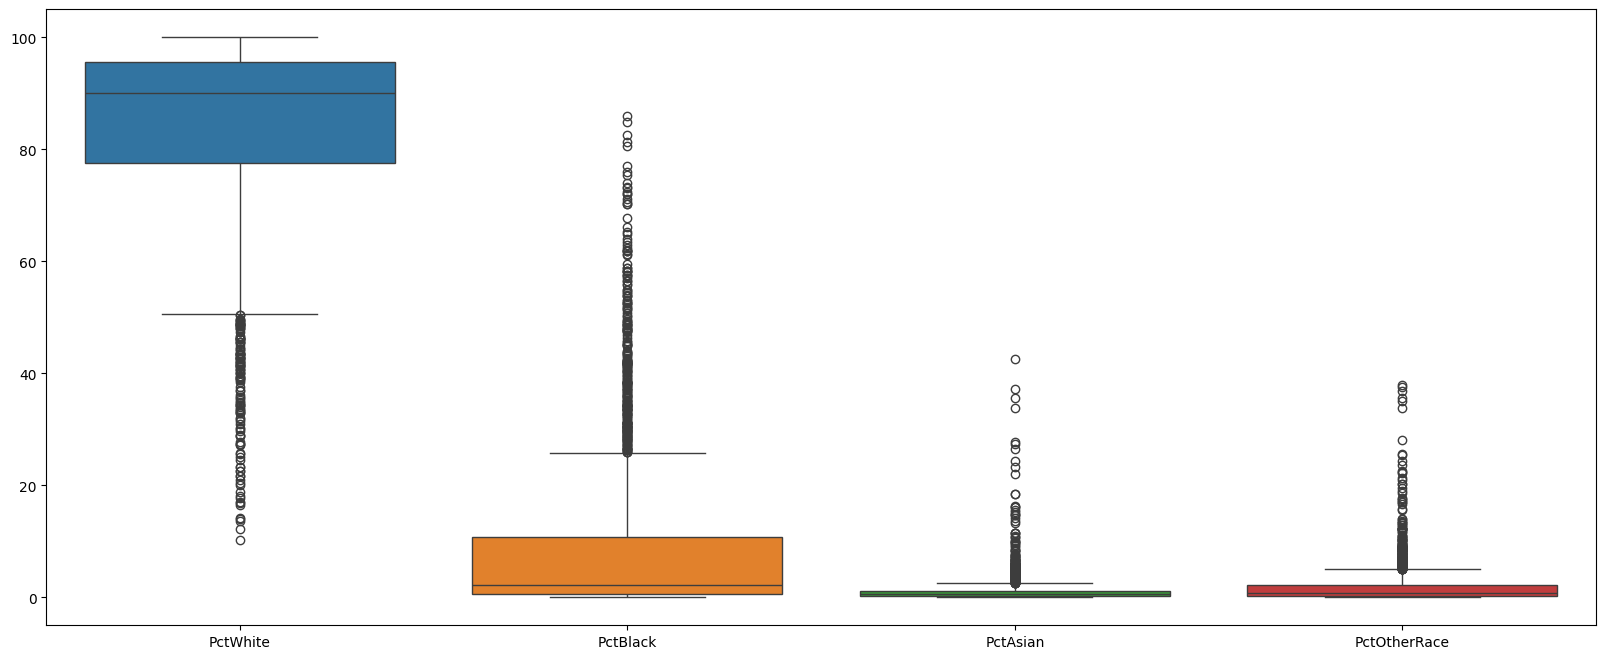

In [28]:
"""   
Se puede observar que hay valores que son muy pequeños como para ser consistentes con la realidad como 11%. Se puede contemplar la posibilidad de que esto se deba a que sea que algunos datos fueron digitados en formatos de porcentajes de 0 a 1 o de 0 a 100, no obstante, con el contexto actual del problema no es posible saber esto y determinarlo seria una tarea muy compleja y podria crear sesgos en el modelo de regresion por etnias.

Por lo que se propone una posible normalizacion sobre todas las columnas dado que no existe tupla cuya suma de los 4 porcentajes sea equivalente a 100%.

La manera en que se realizara esta normalizacion consiste en los siguientes pasos:
- Se hara un analisis descriptivo de las estadisticas de esas 4 columnas antes de la normalizacion, junto a un boxplot. Esto con el objetivo de posterior a la normalizacion comparar que tanto afecto la normalizacion a la naturaleza de los datos y si talvez no sea buena idea realizarla.
- Se hara la normalizacion: se dividira cada valor de cada columna sobre la suma de las 4 columnas, de manera que la suma de los nuevos valores nos den una suma de 100 (en escala de 0 a 100)
- Se hara un nuevo analisis descriptivo de estadisticas junto a un boxplot para analizar que tan bien es la normalizacion para los datos y si no afecta mucho a la naturaleza de los datos. Para anlizar la eficacia de la normalizacion se realizaran las siguientes comparaciones:
        - Comparar la media, la mediana, y la desviación estándar de cada columna antes y después de la normalización, y ver si hay diferencias grandes o pequeñas. Si hay diferencias grandes, significa que la normalización cambió mucho los valores y la dispersión de los datos. Si hay diferencias pequeñas, significa que la normalización no tuvo mucho efecto en los datos.
        - Comparar los diagramas de boxplot de cada columna antes y después de la normalización, y ver si hay cambios en la forma, la posición, y los valores atípicos de los datos. Si hay cambios, significa que la normalización alteró la distribución de los datos. Si no hay cambios, significa que la normalización mantuvo la distribución de los datos.
        - Adicional: verificar los valores de correlacion de cada columna respecto a la variable objetivo (deathRate) para identificar si hubo algun cambio significativo, si hay cambios significativos, significa que la normalización afectó la relación entre las variables. Si no hay cambios, significa que la normalización no tuvo mucho efecto en la relación entre las variables. Lo cual directamente no dice si eso mejora o empeora el modelo y tocaria ser testeado.
"""

target_cols = ["PctWhite", "PctBlack", "PctAsian", "PctOtherRace"]

print(train_data[target_cols].describe())

fig = plt.figure(figsize=(20,8))
ax = sns.boxplot(data=train_data[target_cols], orient="v")



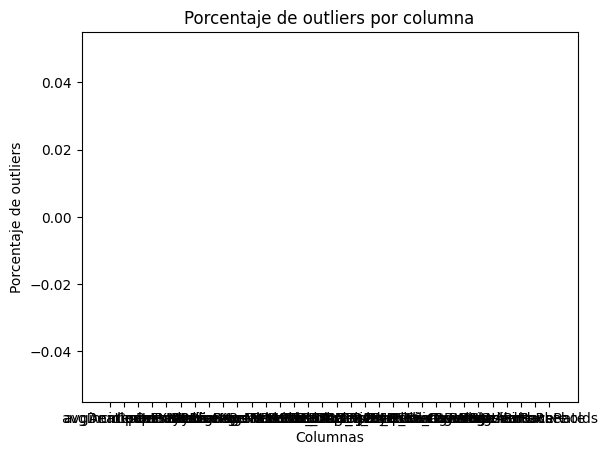

In [29]:
"""   
Identificacion de outliers: para la identificacion de outliers sobre todas las columnas numericas de tipo int64 o float64 se hara por medio del metodo de IQR, donde todos los valores que se encuentren debajo del primer quartil - 1.5*IQR o encima del tercer quartil + 1.5*IQR es considerado un outlier. IQR = Q3 - Q1, quartil 1 = 0.25, quartil 3 = 0.75
"""

# Filtrar las columnas de tipo int64 y float64
df_num = train_data.select_dtypes(include=["int64", "float64"])

# Calcular el primer cuartil (0.25) de cada columna
Q1 = df_num.quantile(0.25)

# Calcular el tercer cuartil (0.75) de cada columna
Q3 = df_num.quantile(0.75)

# Calcular el IQR de cada columna
IQR = Q3 - Q1

# Calcular el límite inferior y superior de cada columna
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR  

# Reindexar el objeto Series lower para que coincida con las etiquetas de df_num
lower = lower.reindex(df_num.index)

# Reindexar el objeto Series upper para que coincida con las etiquetas de df_num
upper = upper.reindex(df_num.index)

# Contar el número de outliers de cada columna
outliers = df_num.apply(lambda x: ((x < lower) | (x > upper)).sum())

# Calcular el porcentaje de outliers de cada columna
percentage = outliers / len(df_num) * 100

# Visualizar el porcentaje de outliers de cada columna
plt.bar(percentage.index, percentage.values)
plt.xlabel("Columnas")
plt.ylabel("Porcentaje de outliers")
plt.title("Porcentaje de outliers por columna")
plt.show()

##### **3. Limpieza y preparacion de datos**

##### **5. Particionamiento del conjunto de datos en entrenamiento y prueba**

En este caso se nos dan dos conjuntos de datos que se han denominado conjunto de entrenamiento y conjunto de validacion, siendo este ultimo un 30% del conjunto total de datos.

Estos datos del conjunto de validacion no se encuentran etiquetados y ese es nuestro proposito y lo que se hara por medio de un modelo de regresion lineal.

Por lo el momento como se nos dieron estos datos de antemano no se considera necesario particionamiento del conjunto de datos en entrenamiento y prueba puesto que ya fue hecho.

##### **6. Entrenamiento de un primer modelo de regresion lineal**

##### **7. Entrenamiento de un segundo modelo aplicando normalizacion**

##### **8. Eleccion de mejor modelo de regresion**

##### **9. Implementación del pipeline con todas las transformaciones requeridas para la generación de predicciones**

##### **10. Exploración de los supuestos de la regresión a partir del mejor modelo**

##### **11. Desarrollo de las transformaciones complementarias para cumplir con los supuestos de la regresión**

##### **12. Interpretación de los coeficientes del modelo**

##### **13. Presentación para CompuAlpes con resultados a nivel cuantitativo y cualitativo del mejor modelo construido**

##### **14. Recomendaciones dadas a CompuAlpes y visualizaciones extraidas del notebook y/o tablero de control**

##### **15. Tablero de control**

##### **16. Persistencia del archivo de predicciones sobre los datos de prueba (CSV)**